<a href="https://colab.research.google.com/github/CarmemMarinho/poscienciasdedados/blob/main/MVP_Srint3_EngenhariaDeDados_Parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP de Engenharia de Dados

Parte 2 - Análise - Qualidade de dados e Solução do Problema

Prof. Victor Almeida

Aluna: Carmem Maria Marinho de Souza Vasconcelos

#1. Importação dos dados

Para realizar as análises, primeiro serão realizadas a importação da tabela, que foi carregada no Big Query na primeira etapa do trabalho, e das bibliotecas a serem utilizadas.

In [1]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'ultra-climber-399402' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

In [2]:
# Importação de Pacotes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# Exibir a consulta usada para gerar o job

job = client.get_job('bquxjob_5ee07767_18ae964c895') # ID do job inserido com base nos resultados da consulta selecionados para explorar
print(job.query)

SELECT * FROM `mvpsprint3.consumidor_masculino`


In [4]:
# Lê os resultados do job
# Carrega os resultados do BigQuery como um DataFrame

job = client.get_job('bquxjob_5ee07767_18ae964c895')
results = job.to_dataframe()
results

,Date,Customer_ID,Age,Product_Category,Quantity,Price_per_Unit,Total_Amount
0,2023-10-18,CUST191,64,Beauty,1,25,25
1,2023-09-28,CUST204,39,Beauty,1,25,25
2,2023-04-23,CUST230,54,Beauty,1,25,25
3,2023-06-03,CUST363,64,Beauty,1,25,25
4,2023-11-29,CUST739,36,Beauty,1,25,25
...,...,...,...,...,...,...,...
485,2023-12-07,CUST531,31,Electronics,1,500,500
486,2023-08-19,CUST638,46,Electronics,1,500,500
487,2023-05-18,CUST818,30,Electronics,1,500,500
488,2023-06-06,CUST867,21,Electronics,1,500,500


##2. Análise

##a) Qualidade dos dados

In [5]:
# Mostra as dimensões do dataset
print(results.shape)

(490, 7)


In [6]:
# Mostra as informações do dataset
print(results.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Date              490 non-null    object
 1   Customer_ID       490 non-null    object
 2   Age               490 non-null    Int64 
 3   Product_Category  490 non-null    object
 4   Quantity          490 non-null    Int64 
 5   Price_per_Unit    490 non-null    Int64 
 6   Total_Amount      490 non-null    Int64 
dtypes: Int64(4), object(3)
memory usage: 28.8+ KB
None


In [7]:
# verificando nulls no dataset
results.isnull().sum()

Date                0
Customer_ID         0
Age                 0
Product_Category    0
Quantity            0
Price_per_Unit      0
Total_Amount        0
dtype: int64

In [8]:
# Verifica o tipo de dataset de cada atributo
results.dtypes

Date                object
Customer_ID         object
Age                  Int64
Product_Category    object
Quantity             Int64
Price_per_Unit       Int64
Total_Amount         Int64
dtype: object

In [9]:
# Faz um resumo estatístico dos atributos numéricos do dataset (média, desvio padrão, mínimo, máximo e os quartis)
results.describe()

,Age,Quantity,Price_per_Unit,Total_Amount
count,490.0,490.0,490.0,490.0
mean,41.428571,2.481633,179.704082,455.428571
std,13.812208,1.133551,190.73602,566.433809
min,18.0,1.0,25.0,25.0
25%,30.0,1.0,30.0,60.0
50%,42.0,2.0,50.0,120.0
75%,54.0,4.0,300.0,900.0
max,64.0,4.0,500.0,2000.0


As variáves numéricas do dataset são "Age", "Quantity", "Price_per_Unit" e "Total_Amount". Seus valores mínimos e máximos são:
Age - Min 18 e Max 64

Quantity - Min 1 e Max 4

Price_per_Unit - Min 25 e Max 500

Total_Amount - Min 25 e Max 2.000


A variável "Product_Category" é a únca variável categórica, formada pelas categorias "Beauty", "Clothing" e "Electronics".

In [10]:
results['Product_Category'].value_counts()

Clothing       177
Electronics    172
Beauty         141
Name: Product_Category, dtype: int64

Conforme observado nas análises acima, não foi necessária nenhuma ação de limpeza de dados, pois, os dados não apresentam erros, nem valores ausentes, nem duplicatas. Entretanto, o dataset não informa as unidades de grandezas dos atributos "Quantity", "Price_per_Unit" e "Total_Amount". Dessa forma, para o desenvolvimento do trabalho, foi utilizadas as unidades de grandezas a seguir:

Quantity - em unidades (un)

Price_per_Unit - em dólares ($)

Total_Amount - em dólares ($)

### b) Solução do Problema

Nessa análise, procurou-se responder as seguintes perguntas:

Existem padrões discerníveis nas vendas em diferentes períodos de tempo?

Quais são as relações entre idade e gastos dos clientes?

Como a idade do cliente influencia no seu comportamento de compra?

Especificamente, vamos buscar responder as questões abaixo:

Qual a faixa etária dos clientes por categoria do produto?

Qual a idade dos clientes que compram mais em quantidade por categoria?

Qual a idade dos clientes que compram mais em valor por categoria?

Qual o mês com maior faturamento por categoria?

Qual o mês com maior quantidade de produtos vendidos por categoria?

Quais meses do ano apresentaram queda no volume de vendas (quantidade)?

Quais meses do ano apresentaram queda no volume de vendas (faturamento)?

Qual a categoria de produto mais vendido em quantidade no período total?

Qual a categoria de produto com maior faturamento no período todo?


In [11]:
# Mostra a quantidade total de produtos vendidos por categoria no período todo
quantidade = results.groupby('Product_Category')['Quantity'].sum()
print (quantidade)

Product_Category
Beauty         353
Clothing       453
Electronics    410
Name: Quantity, dtype: Int64


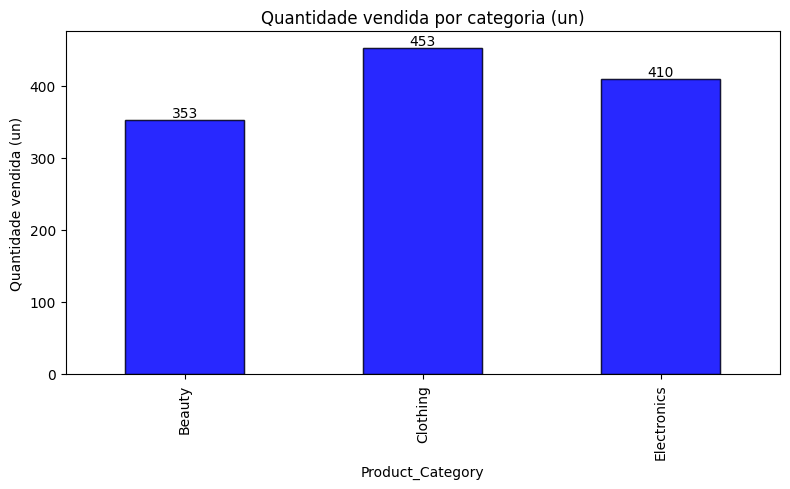

In [25]:
# Gera gráfico da quantidade total de produtos vendidos por categoria no período todo
quantidade = results.groupby('Product_Category')['Quantity'].sum()
quantidade.plot.bar(color='blue', ec='k', alpha=0.6, figsize = (8,5))
plt.yticks(rotation = 360, fontsize=10)
plt.xticks(fontsize=10)

# Acrescenta rótulos dos eixos
plt.xlabel("Categoria", fontsize=10)
plt.ylabel("Quantidade vendida (un)", fontsize=10)

# Acrescenta o título do gráfico
plt.title('Quantidade vendida por categoria (un)')

# Acrescenta os rótulos de dados
ax = quantidade.plot.bar(color='blue', ec='k', alpha=0.6, figsize = (8,5))
ax.bar_label(ax.containers[0], fmt="%.0f", size=10, label_type="edge")

# Ajusta as margens do gráfico
plt.tight_layout()

# Exibe o gráfico
plt.show()

Verificamos que a categoria de produto mais vendido em quantidade no período total é Clothing. Com uma diferença de 100 unidades a mais em comparação com a cateoria Beauty e 43 unidades a mais se comparado com a categoria Electronics.

In [13]:
# Mostra a faturamento total por categoria no período todo
valor = results.groupby('Product_Category')['Total_Amount'].sum()
print (valor)

Product_Category
Beauty         68685
Clothing       74305
Electronics    80170
Name: Total_Amount, dtype: Int64


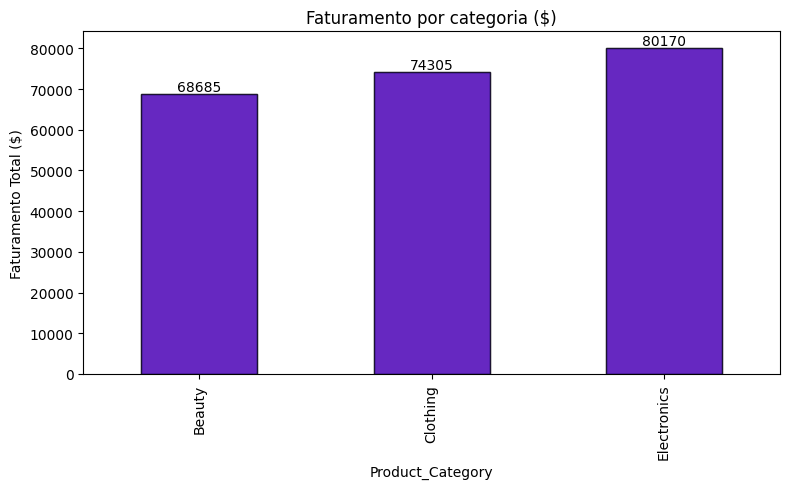

In [24]:
# Gera gráfico da quantidade total de produtos vendidos por categoria no período todo
valor = results.groupby('Product_Category')['Total_Amount'].sum()
valor.plot.bar(color='red', ec='k', alpha=0.6, figsize = (8,5))
plt.yticks(rotation = 360, fontsize=10)
plt.xticks(fontsize=10)

# Acrescenta rótulos dos eixos
plt.xlabel("Categoria", fontsize=10)
plt.ylabel("Faturamento Total ($)", fontsize=10)

# Acrescenta o título do gráfico
plt.title('Faturamento por categoria ($)')

# Acrescenta os rótulos de dados
ax = valor.plot.bar(color='blue', ec='k', alpha=0.6, figsize = (8,5))
ax.bar_label(ax.containers[0], fmt="%.0f", size=10, label_type="edge")

# Ajusta as margens do gráfico
plt.tight_layout()

# Exibe o gráfico
plt.show()

A categoria de produto com maior faturamento no período todo é Electronics. Com diferença de 5.805 a mais em comparação com a categoria Clothing e 11.485 em comparação com a categoria de Beauty.


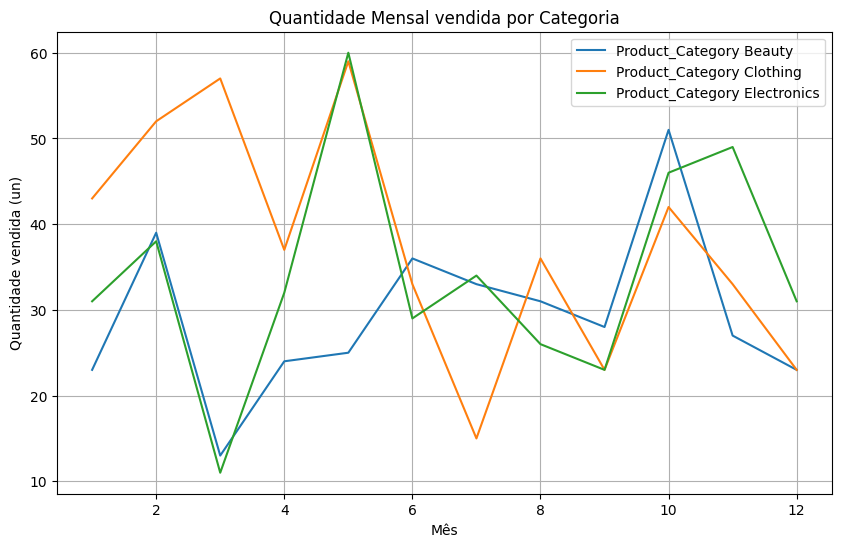

In [15]:
# Gráfico para mostrar a quantidade total de produtos vendidos por mês e categoria
#Selecionar apenas o mês da data
results['Month'] = pd.DatetimeIndex(results['Date']).month

# Agrupar os dados por mês e categoria e somar as vendas
results_grouped = results.groupby(['Month', 'Product_Category']).sum('Quantity').reset_index()

# Criar um gráfico de linha
plt.figure(figsize=(10, 6))
for categoria in results_grouped['Product_Category'].unique():
    data_categoria = results_grouped[results_grouped['Product_Category'] == categoria]
    plt.plot(data_categoria['Month'], data_categoria['Quantity'], label=f'Product_Category {categoria}')

plt.xlabel('Mês')
plt.ylabel('Quantidade vendida (un)')
plt.title('Quantidade Mensal vendida por Categoria')
plt.legend()
plt.grid(True)


# Mostrar o gráfico
plt.show()

O mês de maio apresentou o maior quantidade de produtos vendidos para as categorias Clothing e Electronics. Já para a categoria Beauty, foi o mês de Outubro que ocorreu mais vendas de produtos.

Para as categorias Beauty e Electronics, o mês de março apresenta a maior queda nas vendas em quantidade. Para Clothing as vendas têm sua maior queda em quantidade no mês de julho.

<ipython-input-23-b177343ea089>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_grouped = results.groupby(['Month', 'Product_Category']).sum().reset_index()


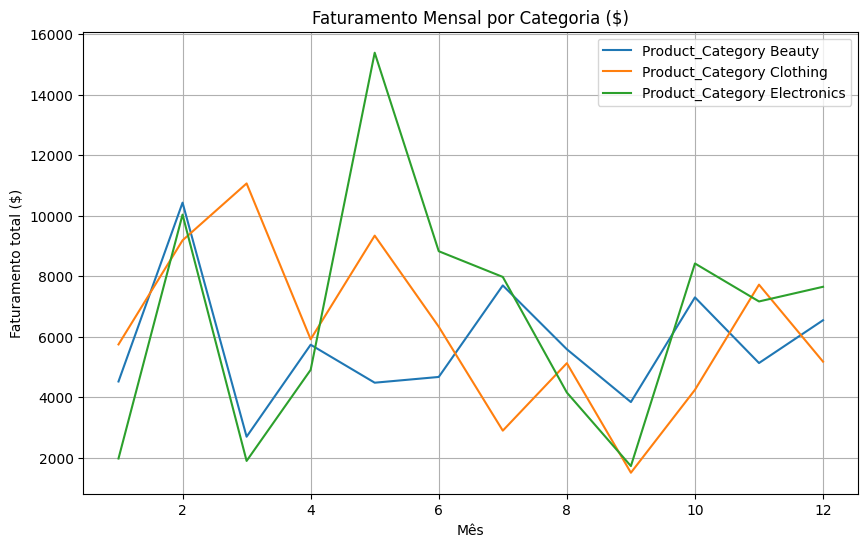

In [23]:
# Gráfico para mostrar o faturamento total por mês e categoria
#Selecionar apenas o mês da data
results['Month'] = pd.DatetimeIndex(results['Date']).month

# Agrupar os dados por mês e categoria e somar as vendas
results_grouped = results.groupby(['Month', 'Product_Category']).sum().reset_index()

# Criar um gráfico de linha
plt.figure(figsize=(10, 6))
for categoria in results_grouped['Product_Category'].unique():
    data_categoria = results_grouped[results_grouped['Product_Category'] == categoria]
    plt.plot(data_categoria['Month'], data_categoria['Total_Amount'], label=f'Product_Category {categoria}')

plt.xlabel('Mês')
plt.ylabel('Faturamento total ($)')
plt.title('Faturamento Mensal por Categoria ($)')
plt.legend()
plt.grid(True)

# Mostrar o gráfico
plt.show()

Na categoria Electronics, o faturamento acompanha o movimento de quantidades vendidas, apresentando o maior valor no mês de maio. Já para Beauty e Clothing, os meses com maior valor de vendas são fevereiro e março, respectivamente.

Conforme observamos no gráfico, na categoria Electronics, percebemos duas grandes quedas no faturamento, uma no mês de março e outra no mês de setembro. As categorias Clothing e Beauty apresentam as maiores quedas no faturamento nos meses de setembro e março, respectivamente.

A categoria Beauty é a que apresenta melhor estabilidade nas vendas ao longo do ano, tanto em quantidade de produtos vendidos, quanto em faturamento total.

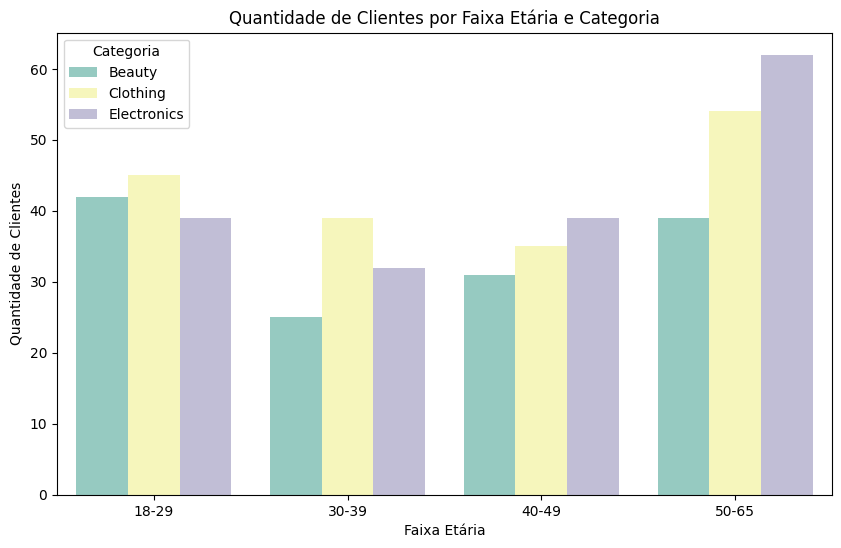

In [17]:
# Gráfico para mostrar a faixa etária dos clientes por categoria do produto
# Criar faixas etárias com base nas idades (visto que a idade mínima e máxima da tabela são 18 e 64 anos)
faixas_etarias = pd.cut(results['Age'], bins=[18, 30, 40, 50, 65], labels=['18-29', '30-39', '40-49', '50-65'])

# Adicionar a coluna de faixa etária ao DataFrame
results['Faixa_Etaria'] = faixas_etarias

# Agrupar os dados por faixa etária e categoria e contar IDs únicos de clientes
faixa_etaria = results.groupby(['Faixa_Etaria', 'Product_Category'])['Customer_ID'].nunique().reset_index()

# Criar um gráfico de barras empilhadas
plt.figure(figsize=(10, 6))
sns.barplot(x='Faixa_Etaria', y='Customer_ID', hue='Product_Category', data=faixa_etaria, palette='Set3')

plt.xlabel('Faixa Etária')
plt.ylabel('Quantidade de Clientes')
plt.title('Quantidade de Clientes por Faixa Etária e Categoria')
plt.legend(title='Categoria')

# Mostrar o gráfico
plt.show()

Na categoria Electronics e Clothing há mais clientes na faixa etária de 50 - 65 anos. Já na categoria Beauty, há mais clientes na faixa etária de 18 - 29 anos.

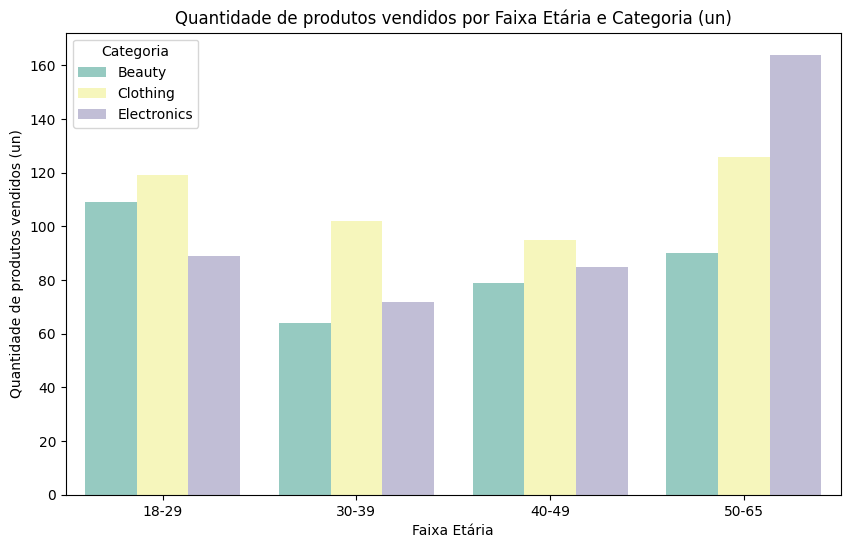

In [26]:
# Gráfico para mostrar a faixa etária dos clientes por categoria do produto e quantidade vendida
# Criar faixas etárias com base nas idades (visto que a idade mínima e máxima da tabela são 18 e 64 anos)
faixas_etarias = pd.cut(results['Age'], bins=[18, 30, 40, 50, 65], labels=['18-29', '30-39', '40-49', '50-65'])

# Adicionar a coluna de faixa etária ao DataFrame
results['Faixa_Etaria'] = faixas_etarias

# Agrupar os dados por faixa etária e categoria e contar IDs únicos de clientes
faixa_etaria = results.groupby(['Faixa_Etaria', 'Product_Category'])['Quantity'].sum().reset_index()

# Criar um gráfico de barras empilhadas
plt.figure(figsize=(10, 6))
sns.barplot(x='Faixa_Etaria', y='Quantity', hue='Product_Category', data=faixa_etaria, palette='Set3')

plt.xlabel('Faixa Etária')
plt.ylabel('Quantidade de produtos vendidos (un)')
plt.title('Quantidade de produtos vendidos por Faixa Etária e Categoria (un)')
plt.legend(title='Categoria')

# Mostrar o gráfico
plt.show()

Conforme verificamos no gráfico, a faixa etária dos clientes em relação a quantidade vendida acompanha o mesmo comportamento do gráfico da faixa etária por quantidade de clientes, para todas as categorias. Os clientes na faixa etária 50 - 65 anos compram mais unidades de produtos das categorias Electronics e Clothing. Já os clientes da faixa etária 18 - 29 anos compram mais unidades de produtos da categoria Beauty.

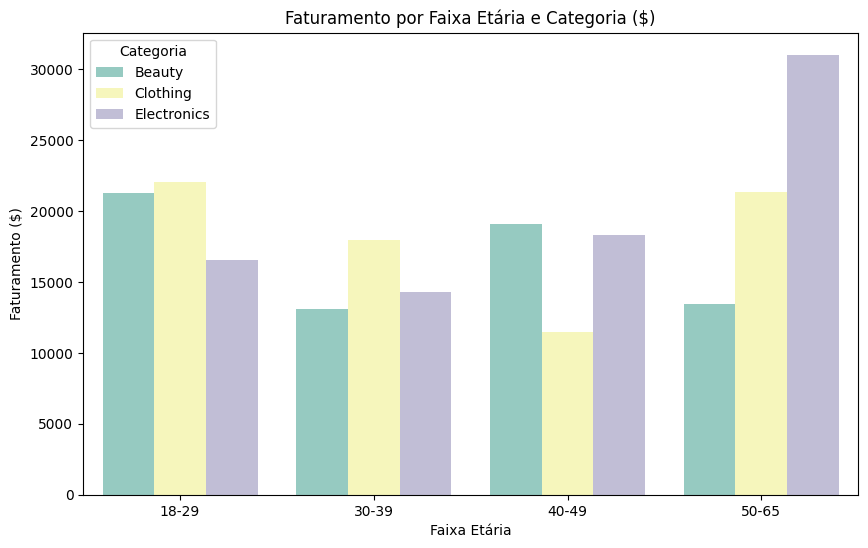

In [21]:
# Gráfico para mostrar a faixa etária dos clientes por categoria do produto e faturamento
# Criar faixas etárias com base nas idades (visto que a idade mínima e máxima da tabela são 18 e 64 anos)
faixas_etarias = pd.cut(results['Age'], bins=[18, 30, 40, 50, 65], labels=['18-29', '30-39', '40-49', '50-65'])

# Adicionar a coluna de faixa etária ao DataFrame
results['Faixa_Etaria'] = faixas_etarias

# Agrupar os dados por faixa etária e categoria e contar IDs únicos de clientes
faixa_etaria = results.groupby(['Faixa_Etaria', 'Product_Category'])['Total_Amount'].sum().reset_index()

# Criar um gráfico de barras empilhadas
plt.figure(figsize=(10, 6))
sns.barplot(x='Faixa_Etaria', y='Total_Amount', hue='Product_Category', data=faixa_etaria, palette='Set3')

plt.xlabel('Faixa Etária')
plt.ylabel('Faturamento ($)')
plt.title('Faturamento por Faixa Etária e Categoria ($)')
plt.legend(title='Categoria')

# Mostrar o gráfico
plt.show()

Os clientes na faixa etária entre 50 - 65 anos estão dispostos a pagar mais por produtos da categoria Electronics. Já para as categorias Beauty e Clothing, o maior faturamento se apresenta para os clientes da faixa etária de 18 - 29 anos.

##Conclusão

Apesar da categoria de produtos Eletrônicos (Electronics) apresentar maior faturamento no ano, a variação mensal é relevante para a estabilidade do negócio. A cateoria de produtos de Beleza (Beauty) têm mais estabilidade no faturamento ao longo o ano. O segmento de Vestuário (Clothing) é o que possui mais produtos vendidos no ano e é o segundo em faturamento anual.

Os clientes que estão dispostos a pagar mais por produtos de Beleza e Vestuário são da mesma faixa etária, entre 18 - 29 anos. Em quantidade de produtos vendidos da categoria Beleza a faixa etária também é de 18 - 29 anos. Para a categoria Vestuário a quantidade de produtos vendidos para a faixa etária entre 18 - 29 anos está bem próxima da quantidade vendida para a faixa etária que compra mais em unidades.

Portanto, concluo que, com base na pesquisa realizada, para o gênero masculino, a orientação para o planejamento do empreendimento seria trabalhar com produtos de vestuário, complementando com produtos da categoria de beleza, utilizando a estratégia de venda de produtos relacionados, que podem ser comprados em conjunto e que servem para ser usados juntos, como um produto complementar. A ideia é que o cliente compre os dois produtos juntos.

## 3. Auto-avaliação

Vou iniciar a auto-avaliação relatando a dificuldade em administrar o tempo, a complexidade das atividades do MVP e a quota de crédito de teste para utilizar as ferramentas do Google Cloud. Especificamente, no catágolo dos dados, fiz a descrição inicial dos atributos, para posteriormente realizar uma revisão e inclusão de algumas informações que estavam faltando, como os valores máximos e mínimos dos atributos "Price_per_Unit" e "Total_Amount". Porém, no momento em que fui fazer esses ajustes a quota de teste da plataforma acabou e a ferramenta não deixou mais salvar as alterações na descrição dos atributos.

A elaboração deste MVP foi bastante relevante para fixação dos assuntos apresentados nas disciplinas e aplicação prática com a rotina do meu trabalho e estimulou a elaboração de estratégias nas minhas atividades de relacionamento com o cliente, na empresa que trabalho, para estender a pesquisa para outros segmentos.